In [1]:
import sys

sys.path.insert(0, '..')

#!{sys.executable} -m pip install folium
#!{sys.executable} -m pip install openapi_core


## Active Cells Performance Algorithm

In the detection of active cells, the algorithm must be able to quickly identify the cells that are within the polygon or line string. The algorithm must be able to handle large grids and complex geometries.
In the previous implementation we have iterated over all the cells in the grid and checked if the cell was within the geometry. This approach is not efficient for large grids and complex geometries.
In this notebook we will implement a new algorithm that is more efficient.

First we define a simple grid with 10 rows and 10 columns.

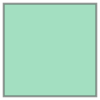

In [2]:
from shapely.geometry import LineString, Polygon, Point, MultiLineString

grid_polygon = Polygon([(0, 0), (0, 10), (10, 10), (10, 0)])
min_x, min_y, max_x, max_y = grid_polygon.bounds

cell_size = 1
rows = 10
row_coords = [i for i in range(rows)] + [rows]

cols = 10
col_coords = [i for i in range(cols)] + [cols]

grid_polygon

### The algorithm will be based on the following steps:
- intersect the grid bounds with the geometry (for the case if the geometry has parts outside the grid)
- create a line string for each row in the grid which goes through the center of the cell

### We create a line string for the representation of each row and column in the grid (through center of the cell)

In [3]:
row_centers = [(row_coords[i] + row_coords[i + 1]) / 2 for i in range(rows)]
row_center_lines = [LineString([(min_x, y), (max_x, y)]) for y in row_centers]

col_centers = [(col_coords[i] + col_coords[i + 1]) / 2 for i in range(cols)]
col_center_lines = [LineString([(x, min_y), (x, max_y)]) for x in col_centers]

### Detection for point geometries:

The algorithm for point geometries is the same as the previous implementation

In [4]:
def get_active_cell(point: Point, r_coords: list, c_coords: list):
  active_cell_col = -1
  active_cell_row = -1

  for y in r_coords:
    if y > point.y:
      break
    active_cell_row += 1

  for x in c_coords:
    if x > point.x:
      break
    active_cell_col += 1

  return active_cell_col, active_cell_row

In [5]:
point = Point(2.1, 5.5)
get_active_cell(point=point, r_coords=row_coords, c_coords=col_coords)

(2, 5)

In [6]:
point = Point(0.1, 0.1)
get_active_cell(point=point, r_coords=row_coords, c_coords=col_coords)

(0, 0)

In [7]:
point = Point(9.1, 9.1)
get_active_cell(point=point, r_coords=row_coords, c_coords=col_coords)

(9, 9)

In [8]:
point = Point(4.25, 0.5)
get_active_cell(point=point, r_coords=row_coords, c_coords=col_coords)

(4, 0)

In [9]:
point = Point(4.25, 1.5)
get_active_cell(point=point, r_coords=row_coords, c_coords=col_coords)

(4, 1)

### Detection for linestring geometries:

  * Intersect the grid bounds with the geometry (for the case if the geometry has parts outside the grid)  
  * Intersect the linestring with linestring representing the row and column lines
  * The results will be stored in a point list
  * Calculate the cells with the algorithm for point geometries
  * It's possible to have multiple points detected for the same cell

In [10]:
linestring = LineString([(2.5, 2.5), (8.5, 10.5)])
print(linestring)

linestring = grid_polygon.intersection(linestring)
print(linestring)

LINESTRING (2.5 2.5, 8.5 10.5)
LINESTRING (2.5 2.5, 8.125 10)


In [11]:
intersections = [linestring.intersection(row_center_line) for row_center_line in row_center_lines] + [linestring.intersection(col_center_line) for col_center_line in col_center_lines]
print(intersections)
intersection_points = [point for point in intersections if point.geom_type == 'Point']
print(intersection_points)

[<LINESTRING Z EMPTY>, <LINESTRING Z EMPTY>, <POINT (2.5 2.5)>, <POINT (3.25 3.5)>, <POINT (4 4.5)>, <POINT (4.75 5.5)>, <POINT (5.5 6.5)>, <POINT (6.25 7.5)>, <POINT (7 8.5)>, <POINT (7.75 9.5)>, <LINESTRING Z EMPTY>, <LINESTRING Z EMPTY>, <POINT (2.5 2.5)>, <POINT (3.5 3.833)>, <POINT (4.5 5.167)>, <POINT (5.5 6.5)>, <POINT (6.5 7.833)>, <POINT (7.5 9.167)>, <LINESTRING Z EMPTY>, <LINESTRING Z EMPTY>]
[<POINT (2.5 2.5)>, <POINT (3.25 3.5)>, <POINT (4 4.5)>, <POINT (4.75 5.5)>, <POINT (5.5 6.5)>, <POINT (6.25 7.5)>, <POINT (7 8.5)>, <POINT (7.75 9.5)>, <POINT (2.5 2.5)>, <POINT (3.5 3.833)>, <POINT (4.5 5.167)>, <POINT (5.5 6.5)>, <POINT (6.5 7.833)>, <POINT (7.5 9.167)>]


In [12]:
active_cells = [get_active_cell(point=point, r_coords=row_coords, c_coords=col_coords) for point in intersection_points]
active_cells

[(2, 2),
 (3, 3),
 (4, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (7, 9),
 (2, 2),
 (3, 3),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 9)]

### Detection for polygon geometries:

* Intersect the grid bounds with the geometry (for the case if the geometry has parts outside the grid)  
* Intersect the polygon with each row line string
  * The result for each row is an empty linestring, a linestring or a multilinestring
  * An empty linestring means that there is no active cell in the row
    * No further calculation is needed for this row
  * A linestring means that there are minimum 1 active cell in the row, not separated by an unactive cell
    * All cells in between the start and end point of the linestring are active
    * Calculate for both points the active cell and fill the space between the points with active cells
     
  * A multilinestring means that there are multiple active cells in the row, separated by an unactive cell
    * Calculate for each linestring the active cell and fill the space between the points with active cells


In [13]:
polygon = Polygon([(2,1), (11,3), (10, 11), (5.5, 8.5), (3,11), (1,9), (2,1)])
print(polygon)

polygon = grid_polygon.intersection(polygon)
print(polygon)

POLYGON ((2 1, 11 3, 10 11, 5.5 8.5, 3 11, 1 9, 2 1))
POLYGON ((4 10, 5.5 8.5, 8.2 10, 10 10, 10 2.7777777777777777, 2 1, 1 9, 2 10, 4 10))


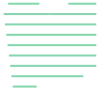

In [14]:
from shapely.lib import intersection

multi_linestring =  MultiLineString([row_center_line.coords for row_center_line in row_center_lines])
intersections = intersection(polygon, multi_linestring)
intersections

In [15]:
print(intersections.geoms)

In [16]:
intersections = [polygon.intersection(row_center_line) for row_center_line in row_center_lines]
intersections

[<LINESTRING Z EMPTY>,
 <LINESTRING (1.938 1.5, 4.25 1.5)>,
 <LINESTRING (1.812 2.5, 8.75 2.5)>,
 <LINESTRING (1.688 3.5, 10 3.5)>,
 <LINESTRING (1.562 4.5, 10 4.5)>,
 <LINESTRING (1.438 5.5, 10 5.5)>,
 <LINESTRING (1.312 6.5, 10 6.5)>,
 <LINESTRING (1.188 7.5, 10 7.5)>,
 <MULTILINESTRING ((1.062 8.5, 5.5 8.5), (5.5 8.5, 10 8.5))>,
 <MULTILINESTRING ((1.5 9.5, 4.5 9.5), (7.3 9.5, 10 9.5))>]

In [17]:
for row, intersection in enumerate(intersections):
  if intersection.is_empty:
    continue
  if intersection.geom_type == 'LineString':
    active_cell_start = get_active_cell(point=Point(intersection.coords[0]), r_coords=row_coords, c_coords=col_coords)
    active_cell_end = get_active_cell(point=Point(intersection.coords[1]), r_coords=row_coords, c_coords=col_coords)
    print(row, active_cell_start, active_cell_end)
    
  if intersection.geom_type == 'MultiLineString':
    line_strings = list(intersection.geoms)
    for line_string in line_strings:
      active_cell_start = get_active_cell(point=Point(line_string.coords[0]), r_coords=row_coords, c_coords=col_coords)
      active_cell_end = get_active_cell(point=Point(line_string.coords[1]), r_coords=row_coords, c_coords=col_coords)
      print(row, active_cell_start, active_cell_end)

1 (1, 1) (4, 1)
2 (1, 2) (8, 2)
3 (1, 3) (10, 3)
4 (1, 4) (10, 4)
5 (1, 5) (10, 5)
6 (1, 6) (10, 6)
7 (1, 7) (10, 7)
8 (1, 8) (5, 8)
8 (5, 8) (10, 8)
9 (1, 9) (4, 9)
9 (7, 9) (10, 9)


In [18]:
intersections = [polygon.intersection(row_center_line) for row_center_line in row_center_lines]
intersections

[<LINESTRING Z EMPTY>,
 <LINESTRING (1.938 1.5, 4.25 1.5)>,
 <LINESTRING (1.812 2.5, 8.75 2.5)>,
 <LINESTRING (1.688 3.5, 10 3.5)>,
 <LINESTRING (1.562 4.5, 10 4.5)>,
 <LINESTRING (1.438 5.5, 10 5.5)>,
 <LINESTRING (1.312 6.5, 10 6.5)>,
 <LINESTRING (1.188 7.5, 10 7.5)>,
 <MULTILINESTRING ((1.062 8.5, 5.5 8.5), (5.5 8.5, 10 8.5))>,
 <MULTILINESTRING ((1.5 9.5, 4.5 9.5), (7.3 9.5, 10 9.5))>]